In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter 
%matplotlib inline
pth = "C:\EPFL\2018-2019\nltk_data" #a changer selon l'endroit ou vous telechargez cela
nltk.data.path.append(pth)


# Data Exploration

In [2]:
liar_df = pd.read_csv('LIAR/train.tsv', sep='\t', header=None)

In [3]:
liar_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


labels : pants-fire, false, barelytrue, half-true, mostly-true, and true (distribution pretty-well balanced) ** other attributes : subject, author of the statement, what the author represent (media, government..), geographic origin (Us state), political party of the author, the credit history vector of the author (counts of pants fire, false, barelytrue...) and the where the statement was emitted. (campaign debate, press release, website...)

In [4]:
liar_df.columns = ['trash', 'label', 'text', 'subject', 'author', 'function', 'state', 'political_party', 'pants_on_fire'\
                  , 'false', 'barely true', 'half true', 'mostly true', 'source']
liar_df = liar_df.drop(columns='trash')
n_rows = liar_df.shape[0]

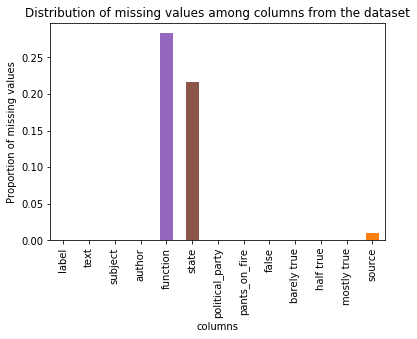

In [5]:
na_values = (liar_df.isnull().sum(axis = 0)/n_rows).plot(kind='bar') #proportion of na values in each column
plt.xlabel('columns')
plt.ylabel('Proportion of missing values')
plt.title('Distribution of missing values among columns from the dataset')
plt.show()

**We can see that except for the function of the author of the news and the state where the news were emitted, most of the data is not missing. However, for these two informations, they may be rather relevant for our classifier for example in terms of credibility (is it a government official saying this fact ?) and also if we want to classify where the fake news are the most spread and if there is some connection between the dominant political party in this state or not. The missing values represent more than 25% of the data for the function of the author and 20% for the state where the news is coming from. Hence we will need to decide after some investigation how to deal with them.**

## News Descriptive Analysis

**In order to have further insigh on what is inside the data. In the next subtask we will at first focus on the text news and their label only.**

In [6]:
news = liar_df[['label', 'text']]

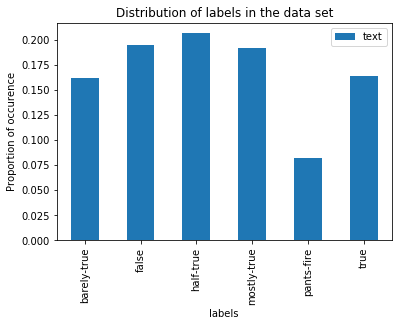

In [7]:
(news.groupby('label').count()/n_rows).plot(kind='bar')
plt.xlabel('labels')
plt.ylabel('Proportion of occurence')
plt.title('Distribution of labels in the data set')
plt.show()

**We can see that the distribution of the 6 labels is quite balanced except for the pants-fire label which is less present than the other labels present roughly a little bit less than 20% of the time.**

In [8]:
text = news[['label', 'text']]

In [9]:
def tokenization(t) : 
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    return tokenizer.tokenize(t)

In [10]:
for i in range(n_rows) : 
    t = text.iloc[i][1]
    text.iloc[i][1] = tokenization(t)

Separate the text according to their labels

In [11]:
false_news = text[text['label'] == 'false']
half_true_news =  text[text['label'] == 'half-true']
mostly_true_news =  text[text['label'] == 'mostly-true']
barely_true_news =  text[text['label'] == 'barely-true']
pants_fire_news =  text[text['label'] == 'pants-fire']
true_news =  text[text['label'] == 'true']

**Get most common words in text**

In [12]:
stopwords = ''
with open('stopw.txt') as f:
        # return the split results, which is all the words in the file.
        stopwords = f.read().split()

In [13]:
#helper function use to concatenate all sentences in big paragraph of words.
def create_dataset(array) :
    dataset = ''
    for i in range(len(array)) :
        dataset += ' '.join(array[i])
        dataset += ' '
    split_it = dataset.split()
    counter = Counter(split_it)
    return counter


def text_to_topics(df, sw) :
    #Get the sentences from the dataset
    sentences = df['text'].values
    
    #transform sentences to word tokens
    stemmer = nltk.stem.PorterStemmer()
    wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
    s = [[wordnet_lemmatizer.lemmatize(token) for token in li] for li in sentences]
    
    #transform word to lowercase and filter out stopwords
    for i in range(len(s)) :
        temp = []
        sent = s[i]
        for j in range(len(sent)) :#
            w = sent[j].lower()
            if(not w in sw) :
                #print('words : {}'.format(w))
                temp.append(w)
        s[i] = temp
    
    #return the topics
    dataset = create_dataset(s)
    dataset = pd.DataFrame(list(dataset.items()), columns=['word', 'occurences'])
    dataset = dataset.sort_values(by='occurences', ascending=False)
    return dataset

In [14]:
n =10

In [15]:
false_news_topics = text_to_topics(false_news, stopwords).head(n)
half_true_topics = text_to_topics(half_true_news, stopwords).head(n)
mostly_true_topics = text_to_topics(mostly_true_news, stopwords).head(n)
barely_true_topics = text_to_topics(barely_true_news, stopwords).head(n)
pants_fire_topics = text_to_topics(pants_fire_news, stopwords).head(n)
true_topics = text_to_topics(true_news, stopwords).head(n)

In [16]:
def show_topics(df, title, n) :
    df.plot(kind='bar', x='word', y='occurences')
    plt.title('{} most popular topics in {} news'.format(n, title))
    plt.xlabel('topics')
    plt.ylabel('occurences')
    plt.show()

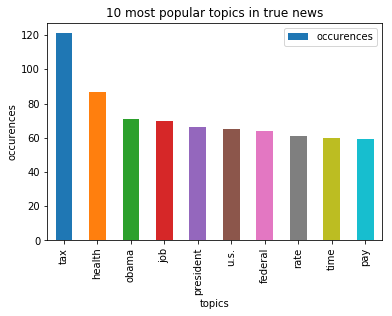

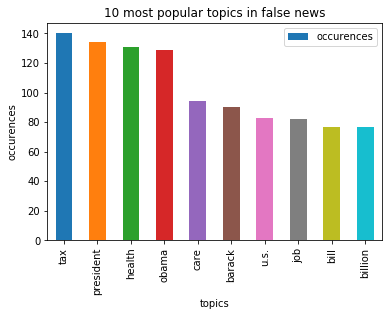

In [17]:
show_topics(true_topics, 'true', n)
show_topics(false_news_topics, 'false', n)

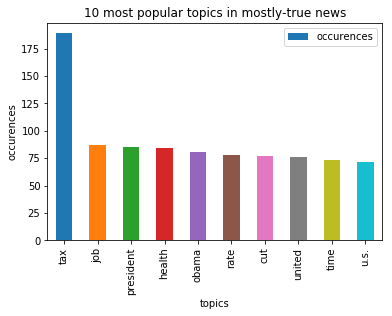

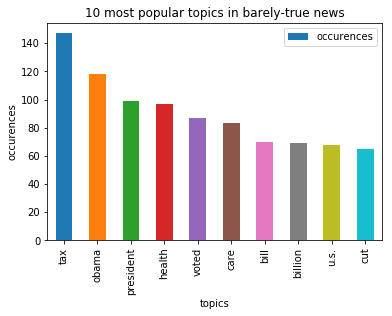

In [18]:
show_topics(mostly_true_topics, 'mostly-true', n)
show_topics(barely_true_topics, 'barely-true', n)

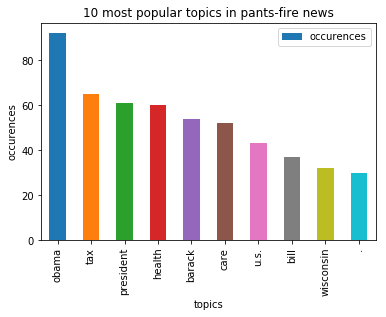

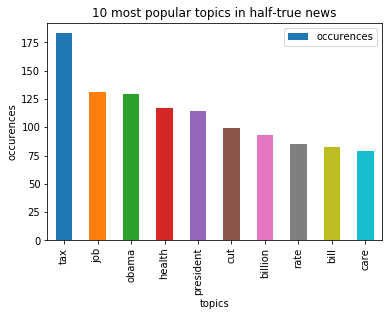

In [19]:
show_topics(pants_fire_topics, 'pants-fire', n)
show_topics(half_true_topics, 'half-true', n)

**and in the whole corpus**

In [20]:
whole_topics = text_to_topics(text, stopwords).head(n)

In [21]:
whole_topics.head()

,word,occurences
196,tax,845
265,obama,620
28,health,576
318,president,559
430,job,447


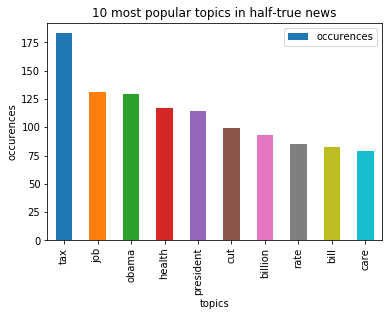

In [22]:
show_topics(half_true_topics, 'half-true', n)

## Where are they coming from ?

In [23]:
states = liar_df[['label', 'state']].dropna()

**There are 84 states in the dataset, we should only have maximum 50 ones. When looking at the data, it seems that some of them have been spelled incorrectly. In order to do it, we will used cosine similarity from a dictionnary of states to find the closest string representing a state that matche the ones in the dataset.**

In [24]:
def get_cosine(vec1, vec2) :
    l1 = len(vec1)
    l2 = len(vec2)
    k = l1
    if(l2 < l1) :
        k = l2
    p = 0
    for i in range(k) :
        if(vec1[i] in vec2) :
            p += 1
    return p/l2

def find_closest(old_text, list_text) :
    if(old_text == 'District of Columbia') :
        return "Washington"
    cosines = []
    for i in range(len(list_text)) :
        v = list_text[i]
        cos = get_cosine(old_text, v)
        cosines.append(cos)
    index = np.argmax(cosines)
    return list_text[index]

In [25]:
correct_states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

**try to correct the data set now**

In [26]:
states.groupby('state').count().head()

,label
state,
Alabama,14
Alaska,65
Arizona,182
Arkansas,84
Atlanta,1


À enlever : China et the united states

In [27]:
states_Copy = states.copy()
states_Copy.state = states_Copy.state.apply(lambda x : find_closest(x, correct_states))
scores = {'true' : 1, 'mostly-true' : 0.6, 'half-true' : 0.2, 'barely-true' : -0.2, 'pants-fire' : -0.6, 'false' : -1}
states_Copy['score'] = states_Copy.label.apply(lambda x : scores.get(x))
states_score = states_Copy.groupby('state').sum().reset_index()

In [28]:
states_score.sort_values('score', ascending=False).head(10)

,state,score
12,Illinois,125.6
33,Ohio,108.8
8,Florida,100.2
9,Georgia,55.0
37,Rhode Island,37.4
41,Texas,31.2
35,Oregon,31.2
28,New Jersey,30.6
44,Virginia,24.6
43,Vermont,21.6


**Let's add some visualization to our results**

In [29]:
import json
import folium

C:\Anaconda\envs\ada\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.24) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [30]:
state_geo_path = r'us-states.json'
geo_json_data = json.load(open(state_geo_path))

In [31]:
us_map = folium.Map(location=[48, -102], zoom_start=3)
us_map.choropleth(geo_data=geo_json_data, data=states_score,
             columns=['state', 'score'],
             key_on='feature.properties.name',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Credit History of USA states')
us_map

**Looking at the map, the general trend shows that the more we go towards west the less reliable are the news. Globally, on average there is clear majority of states having a negative credit history among all the states in opposition to states having a positive history.**

**A next step would be to visualize and compare political party credit history**

# Feature Engineering

**We will use two different approach and compare between each, which one gives better result and see if they match with hypothesis gotten in the data exploration task.
In order to contruct our predictor, we need to create good features to help our algorithm to work well. Here are the different approaches we will try.**

## 1) Bag of words  (labels + text only)

We don't need high freq n-grams and low-freq n-grams (stop-words and typos. don't need them or we will overfit)
Hence we will keep medium frequency n-grams. which one are good ?
The n-gram with smaller freq can be more discriminating because it can capture a specific issue/pattern in the news. 

In order to capture this idea, we will use TF-IDF :
 
TERM FREQUENCY (tf)
tf(t, d) : token freq in doc D
Use either term freq : f(t, d) / sum(f(t', d)) OR log normalization 1 + log(f(t, d)) with f(t,d) being the raw count of t in d.


INVERSE DOCUMENT FREQUENCY (IDF)
idf(t, D) = log(N / number of docs (news for us) where t appears) with N = number of docs in corpus (number of news) 

TF-IDF VALUE
tfidf(t, d, D) = tf(t, d) * idf(t, D)
high weight is reached by high term freq and low doc freq of the term in whole corpus.
IDEA : find frequent terms in news that are not so frequent in whole data set.
So replace counters with TF-IDF and normalize results row-wise (divide by L2 norm)

## 2) Is the geographical origin of the news relevant?

We will add to our feature the state where the news come from and check whether our predictor behave better.
According to our descripitive analysis above, this feature can enhance our results since it contains some hidden informations, indeed depending where the news is coming from, thanks to the credit history of a state, we can trust or question the information at first sight.

## 3) Is the political party where the news comes from is relevant?

Similar analysis

# Applied ML 

**At first, we will use a linear classification model (logistic regression) for our prediction task. Since its linear it can handle sparse data and weights can be interpreted. (positive weights mapped to "true news", neg ones to "fake news".) (PRINT TOP POS WEIGHTS WITH CORRESPONDING N GRAMS AND TOP NEG)**

This analysis will allow us to distinguish which fakes news are the most popular (topics). Can we question the fake news depending on its geographical origin or political party origin and others...?